<a href="https://colab.research.google.com/github/ukablahblah/MentalHealthAppReview/blob/main/MentalHealthApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install google-play-scraper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.9 MB/s eta 0:00:00


In [3]:
from google_play_scraper import reviews
import pandas as pd

apps = {
    "Calm": "com.calm.android",
    "BetterHelp": "com.betterhelp",
    "Youper": "br.com.youper",
    "Shine": "com.shinetext.shine",
    "Wysa": "bot.touchkin",
    "Happify": "com.happify.happifyinc",
    "MindDoc": "de.moodpath.android",
    "Insight Timer": "com.spotlightsix.zentimerlite2",
    "Aura": "com.aurahealth",
    "Simple Habit": "com.simplehabit.simplehabitapp"
}



all_reviews = []

for app_name, package in apps.items():
    print(f"Scraping {app_name}...")
    result, _ = reviews(
        package,
        lang='en',
        country='us',
        count=5000,
        filter_score_with=None
    )

    if not result:
        print(f"⚠️ No reviews found for {app_name}. Skipping.")
        continue

    # Check for required keys
    sample = result[0]
    expected_keys = ['userName', 'score', 'at', 'content']
    if not all(key in sample for key in expected_keys):
        print(f"⚠️ Unexpected format for {app_name}. Skipping.")
        continue

    df = pd.DataFrame(result)[['userName', 'score', 'at', 'content']]
    df.columns = ['user', 'rating', 'date', 'review']
    df['app'] = app_name
    all_reviews.append(df)

# Combine if there's any data
if all_reviews:
    df_all = pd.concat(all_reviews)
    df_all.to_csv("mental_health_reviews.csv", index=False)
    print("✅ Done. Saved as 'mental_health_reviews.csv'")
else:
    print("❌ No valid review data scraped.")


Scraping Calm...
Scraping BetterHelp...
Scraping Youper...
Scraping Shine...
Scraping Wysa...
Scraping Happify...
Scraping MindDoc...
Scraping Insight Timer...
Scraping Aura...
Scraping Simple Habit...
✅ Done. Saved as 'mental_health_reviews.csv'


In [4]:
import pandas as pd

df = pd.read_csv("mental_health_reviews.csv")
df.head()
df['app'].value_counts()


,count
app,
Calm,5000
BetterHelp,5000
Youper,5000
Wysa,5000
MindDoc,5000
Insight Timer,5000
Simple Habit,5000
Shine,4456
Aura,4084


In [5]:
!pip install nltk textblob

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import re

nltk.download('stopwords')
nltk.download('wordnet')

# Load data
df = pd.read_csv("mental_health_reviews.csv")

# Remove duplicates based on user + date + review text
df = df.drop_duplicates(subset=['user', 'date', 'review'])

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Setup for cleaning
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(tokens)

# Clean reviews
df['clean_review'] = df['review'].apply(clean_text)

# Sentiment polarity (-1 to 1)
df['sentiment'] = df['clean_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


,user,rating,date,review,app,clean_review,sentiment
0,A Google user,5,2025-07-21 00:11:24,love this. Just starting to try and work on my...,Calm,love starting try work amazing,0.366667
1,A Google user,1,2025-07-20 22:17:08,because it has no pop music,Calm,pop music,0.000000
2,A Google user,2,2025-07-20 17:29:13,At least I found the Calmings again!,Calm,least found calming,-0.300000
3,A Google user,5,2025-07-20 13:14:33,I have used the app for 4+ years and absolutel...,Calm,used app year absolutely love however recently...,0.250000
4,A Google user,5,2025-07-20 10:52:59,Established essential ✨️,Calm,established essential,0.000000


In [6]:
!pip install matplotlib seaborn pandas nltk textblob

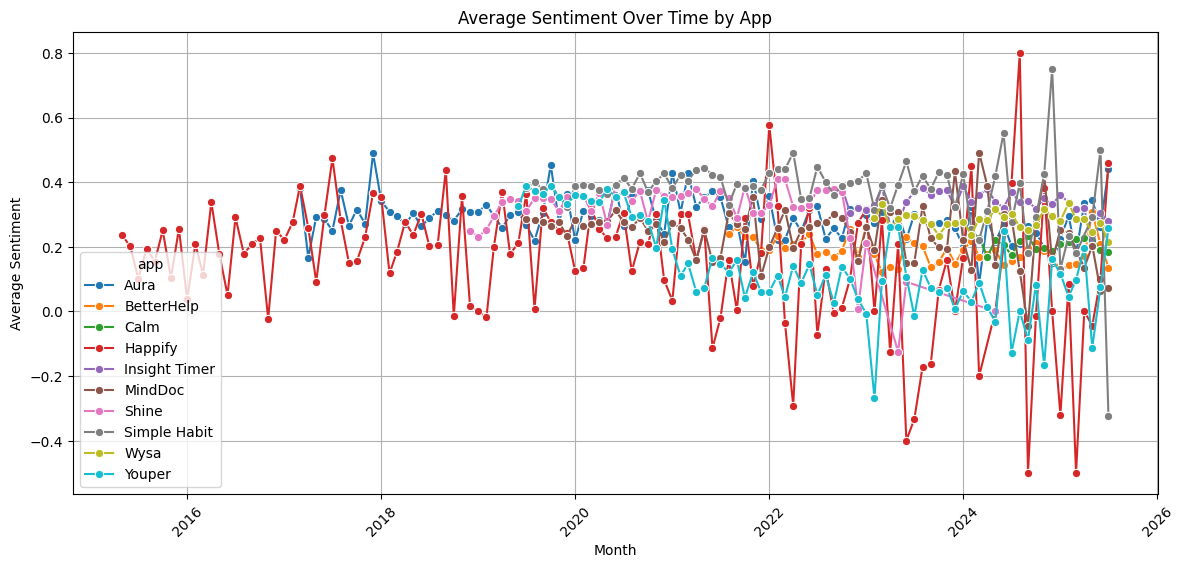

/tmp/ipython-input-7-1817949837.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=installs_df, x='app', y='installs', palette='gray')


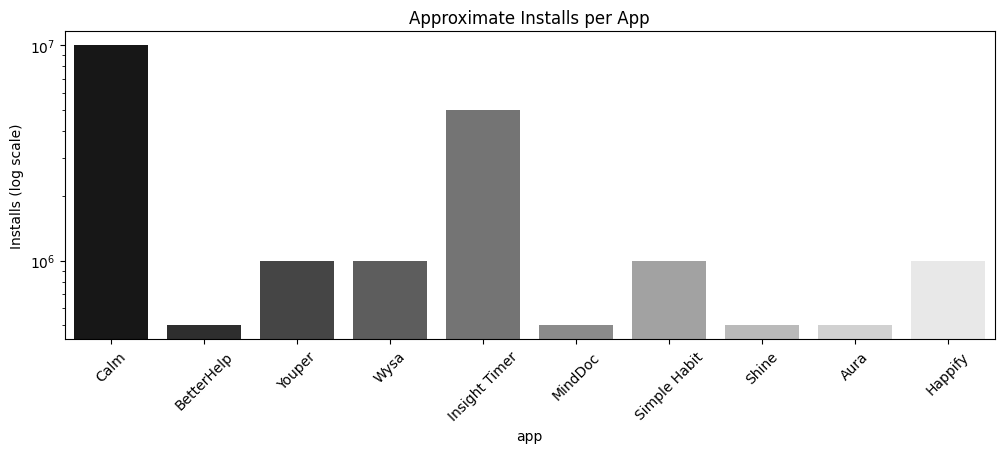

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare sentiment data
df['month'] = df['date'].dt.to_period('M')
sentiment_time = df.groupby(['app', 'month'])['sentiment'].mean().reset_index()
sentiment_time['month'] = sentiment_time['month'].dt.to_timestamp()

# Installs dict
installs = {
    "Calm": 10000000,
    "BetterHelp": 500000,
    "Youper": 1000000,
    "Wysa": 1000000,
    "Insight Timer": 5000000,
    "MindDoc": 500000,
    "Simple Habit": 1000000,
    "Shine": 500000,
    "Aura": 500000,
    "Happify": 1000000
}
installs_df = pd.DataFrame(list(installs.items()), columns=['app', 'installs'])

# Plot sentiment trends
plt.figure(figsize=(14, 6))
sns.lineplot(data=sentiment_time, x='month', y='sentiment', hue='app', marker='o')
plt.title('Average Sentiment Over Time by App')
plt.xlabel('Month')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot installs bar chart separately
plt.figure(figsize=(12, 4))
sns.barplot(data=installs_df, x='app', y='installs', palette='gray')
plt.yscale('log')
plt.ylabel('Installs (log scale)')
plt.title('Approximate Installs per App')
plt.xticks(rotation=45)
plt.show()


In [8]:
!pip install gensim nltk

In [9]:
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Filter negative reviews
neg_reviews = df[df['sentiment'] < 0]['clean_review'].tolist()

# Tokenize
tokenized_reviews = [review.split() for review in neg_reviews]

# Remove stopwords again (optional safety)
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_reviews = [[word for word in doc if word not in stop_words] for doc in tokenized_reviews]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]


In [11]:
lda_model = gensim.models.LdaModel(
    corpus,
    num_topics=5,
    id2word=dictionary,
    passes=10,
    random_state=42
)


In [12]:
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx + 1}:")
    print(topic)
    print()


Topic 1:
0.039*"app" + 0.019*"meditation" + 0.016*"day" + 0.015*"time" + 0.010*"ive" + 0.008*"im" + 0.007*"long" + 0.007*"even" + 0.006*"feel" + 0.006*"using"

Topic 2:
0.043*"app" + 0.014*"like" + 0.012*"time" + 0.012*"help" + 0.012*"im" + 0.011*"really" + 0.010*"one" + 0.010*"get" + 0.009*"meditation" + 0.008*"dont"

Topic 3:
0.040*"app" + 0.033*"mental" + 0.029*"health" + 0.013*"helpful" + 0.011*"help" + 0.010*"people" + 0.008*"worst" + 0.008*"data" + 0.008*"extremely" + 0.007*"ever"

Topic 4:
0.025*"app" + 0.020*"money" + 0.017*"subscription" + 0.016*"waste" + 0.013*"expensive" + 0.013*"time" + 0.012*"cancel" + 0.012*"dont" + 0.010*"even" + 0.010*"trial"

Topic 5:
0.024*"help" + 0.023*"app" + 0.019*"pay" + 0.012*"free" + 0.011*"like" + 0.010*"people" + 0.008*"u" + 0.008*"hate" + 0.008*"expensive" + 0.007*"content"



In [15]:
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
import nltk

# Download once
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = {'app', 'im', 'ive', 'like', 'get', 'even', 'really', 'dont', 'one', 'use', 'used', 'time'}
stop_words.update(custom_stopwords)

# Clean and tokenize reviews
neg_reviews = df[df['sentiment'] < 0]['clean_review'].tolist()

tokenized_reviews = [
    [word for word in simple_preprocess(doc) if word not in stop_words]
    for doc in neg_reviews
]

# Remove short ones
tokenized_reviews = [doc for doc in tokenized_reviews if len(doc) > 2]

# Create dictionary and corpus
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

# Train LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    passes=10,
    random_state=42
)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
!pip install pyLDAvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 48.7 MB/s eta 0:00:00


In [17]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


In [22]:
texts = tokenized_reviews

# Trim original dataframe to match length of texts
df_cleaned = df[df['sentiment'] < 0].iloc[:len(texts)].copy()

# LDA topic inference
topics_per_doc = lda_model[corpus]
doc_topics = [max(doc, key=lambda x: x[1])[0] for doc in topics_per_doc]

# Assign topics
df_cleaned['dominant_topic'] = doc_topics

topic_labels = {
    0: "Therapist Support & Mental Health Sessions",
    1: "Subscription and Billing Complaints",
    2: "Guided Meditation and Daily Habits",
    3: "Positive Impact & Emotional Benefits",
    4: "App Performance Issues"
}
df_cleaned['topic_label'] = df_cleaned['dominant_topic'].map(topic_labels)


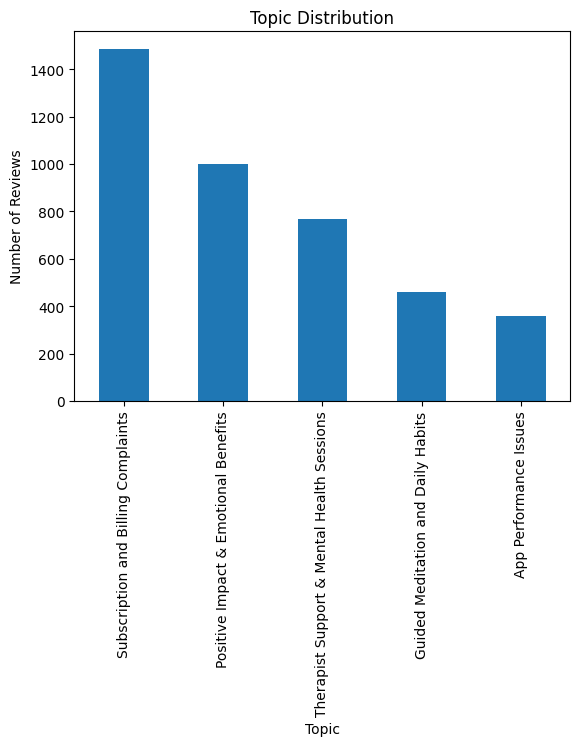

In [23]:
import matplotlib.pyplot as plt

df_cleaned['topic_label'].value_counts().plot(kind='bar', title='Topic Distribution')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.show()


In [24]:
for topic in df_cleaned['dominant_topic'].unique():
    print(f"\nTopic {topic} — {topic_labels[topic]}")
    print(df_cleaned[df_cleaned['dominant_topic'] == topic]['review'].sample(3, random_state=1).to_string(index=False))



Topic 4 — App Performance Issues
It's a decent app, but there's a serious notifi...
Too complicated! When truly anxious, concentrat...
                                Unable to open app

Topic 1 — Subscription and Billing Complaints
                                   waste of money.
The fact that there's not opinion to put in you...
Wasted my time as I didn't realize it was a tri...

Topic 0 — Therapist Support & Mental Health Sessions
App worked smoothly and is easy to navigate. Th...
              Everything is locked behind paywall.
Not free at all, it keeps demanding I pay for a...

Topic 2 — Guided Meditation and Daily Habits
                    awful 😐 everything is premium!
All therapists I've had with this app were extr...
I like when it asks me how I'm doing three time...

Topic 3 — Positive Impact & Emotional Benefits
Your daily notifications and affirmations are s...
The only difficult I found is that it doesn't w...
I really liked and depended on using this for s...
